# Liger and my ROPE complex can be slower
### Purpose
My implementation can be slower when we use complex numbers.

### Problem

When tested with torch compile it seems that complex numbers might be slower, there is warning that appears during compilation, also it is mentioned online in several discussions. <TODO LINK THEM HERE>

### Process
* Create non complex impl
* Verify that it is identical to complex and LIGER.
* Benchmark both with and without torch compile.
* Compare with LIGER (this will be inconclusive since my GPU is not the newest one and its memory is quite limited)


In [1]:
import torch
import pytest
import matplotlib.pyplot as plt
from models.gpt_2_baseline_liger import Attention, GPT2Configuration
from liger_kernel.transformers.rope import LigerRopeFunction
from liger_kernel.transformers.functional import liger_rope
from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb


/home/tsikora/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First implement non complex version of my ROPE. Evaluate if it is identical to complex and LIGER.

In [6]:

def complex_precompute_freqs_cis(dim: int, end: int, device=None, theta=10000.0):
 # Make sure we're using half dimension since we'll duplicate later

    # This is the key change - use torch.arange(0, dim, 2) instead of just torch.arange
    freqs = 1.0 / (theta ** (torch.arange(0, dim , 2, dtype=torch.float32) / (dim)))

    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [end, dim/2]

    # Convert to complex numbers
    freqs_cis = freqs_cis = torch.complex(torch.cos(freqs), torch.sin(freqs))

    return freqs_cis


def complex_apply_rotary_position_embedding(q, k, freqs_cis_sp):  # [batch,heads,seq,dim]
    """
    Example of reorganizing q, k so that the first half
    is real and the second half is imaginary, then
    doing complex multiply to match Llama's results.
    """
    # Reorder q, k so that their last dim is [half, 2]

    q_ri =  torch.stack((q[..., :q.shape[-1] // 2], q[..., q.shape[-1] // 2:]), dim=-1)
    k_ri =  torch.stack((k[..., :k.shape[-1] // 2], k[..., k.shape[-1] // 2:]), dim=-1)

    # Now interpret as complex
    q_complex = torch.view_as_complex(q_ri)  # shape [batch, heads, seq, half]
    k_complex = torch.view_as_complex(k_ri)

    # freqs_cis should have shape [seq, half] or broadcastable
    # Multiply => apply rotation
    q_rotated = q_complex * freqs_cis_sp   # shape [batch, heads, seq, half]
    k_rotated = k_complex * freqs_cis_sp

    # Convert back to real
    q_ri_out = torch.view_as_real(q_rotated)  # shape [..., half, 2]
    k_ri_out = torch.view_as_real(k_rotated)

    # "Unstack" them so that the last dimension is 2*half = dim
    # which is [real, imag] => cat => [..., dim]
    q_out = torch.cat([q_ri_out[..., 0], q_ri_out[..., 1]], dim=-1)
    k_out = torch.cat([k_ri_out[..., 0], k_ri_out[..., 1]], dim=-1)

    return q_out, k_out



def precompute_freqs_cis(dim: int, end: int, device=None, theta=10000.0):
 # Make sure we're using half dimension since we'll duplicate later

    # This is the key change - use torch.arange(0, dim, 2) instead of just torch.arange
    freqs = 1.0 / (theta ** (torch.arange(0, dim , 2, dtype=torch.float32) / (dim)))

    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [end, dim/2]

    return torch.cos(freqs).to(device), torch.sin(freqs).to(device)


def apply_rotary_position_embedding(q, k,  cos, sin):  # [batch,heads,seq,dim]
    # Reorder q, k so that their last dim is [half, 2]
    q_ri =  torch.cat((-q[..., q.shape[-1] // 2:], q[..., :q.shape[-1] // 2]), dim=-1)
    k_ri =  torch.cat((-k[..., k.shape[-1] // 2:], k[..., :k.shape[-1] // 2]), dim=-1)

    # freqs_cis should have shape [seq, half] or broadcastable
    # Multiply => apply rotation
    cos = cos.unsqueeze(1)
    sin = sin.unsqueeze(1)

    q_rotated = (q * cos) + (q_ri * sin)
    k_rotated = (k * cos) + (k_ri * sin)
    return q_rotated, k_rotated


if not torch.cuda.is_available():
    pytest.skip("CUDA required for this test")

device = torch.device('cuda')

# Set seed for reproducibility
torch.manual_seed(42)

# Create small test input
batch_size = 1
seq_len = 128
d_model = 128
num_heads = 2

x = torch.randn(batch_size, seq_len, d_model, device=device)

# Create both configurations
config_standard = GPT2Configuration(block_size=128, d_model=d_model, num_heads=num_heads, use_liger=False)

attention_standard = Attention(config_standard).to(device)
B, S, D = x.size()
head_dim = D // config_standard.num_heads

qkv_bhsd = map(lambda t: t.view(B, S, config_standard.num_heads, head_dim).transpose(1, 2),
                attention_standard.c_attn(x).chunk(3, dim=-1))
q_bhsd, k_bhsd, v_bhsd = qkv_bhsd

freqs_cis_sp_complex = complex_precompute_freqs_cis(
    config_standard.d_model // config_standard.num_heads,
    config_standard.block_size,
    device=device
).to(device)

cos_complex = torch.cat([freqs_cis_sp_complex.real, freqs_cis_sp_complex.real], dim=-1).unsqueeze(0)  # [1, seq, dim]
sin_complex = torch.cat([freqs_cis_sp_complex.imag , freqs_cis_sp_complex.imag ], dim=-1).unsqueeze(0)  # [1, seq, dim]
q_rope_complex, k_rope_complex = complex_apply_rotary_position_embedding(q_bhsd, k_bhsd, freqs_cis_sp_complex[:S])

cos, sin = precompute_freqs_cis(
    config_standard.d_model // config_standard.num_heads,
    config_standard.block_size,
    device=device
)

l_q_rope, l_k_rope = LigerRopeFunction.apply(
    q_bhsd, k_bhsd,
    cos[:, :S], sin[:, :S],
    None,
    1    # unsqueeze_dim
)


cos = torch.cat([cos, cos], dim=-1).unsqueeze(0)  # [1, seq, dim]
sin = torch.cat([sin , sin], dim=-1).unsqueeze(0)  # [1, seq, dim]

print("cos shape:", cos.shape)
print("sin shape:", sin.shape)
print("cos first few:", cos[0,0,:5])
print("sin first few:", sin[0,0,:5])
q_rope, k_rope = apply_rotary_position_embedding(q_bhsd, k_bhsd, cos[:S],  sin[:S])

sin_close_to_sin_complex = torch.allclose(sin_complex, sin, rtol=1e-5, atol=1e-5)
print(f"sin_complex and sin are close: {sin_close_to_sin_complex}")

cos_close_to_cos_complex = torch.allclose(cos_complex, cos, rtol=1e-5, atol=1e-5)
print(f"cos_complex and cos are close: {cos_close_to_cos_complex}")

q_rope_close_to_q_rope_complex = torch.allclose(q_rope_complex, q_rope, rtol=1e-5, atol=1e-5)
print(f"q_rope_complex and q_rope are close: {q_rope_close_to_q_rope_complex}")

k_rope_close_to_k_rope_complex = torch.allclose(k_rope_complex, k_rope, rtol=1e-5, atol=1e-5)
print(f"k_rope_complex and k_rope are close: {k_rope_close_to_k_rope_complex}")

print("l_q_rope dtype:", l_q_rope.dtype)
print("q_rope dtype:", q_rope.dtype)
l_q_rope_close_to_q_rope = torch.allclose(l_q_rope, q_rope, rtol=1e-5, atol=1e-5)
print(f"l_q_rope and q_rope are close: {l_q_rope_close_to_q_rope}")

l_k_rope_close_to_k_rope = torch.allclose(l_k_rope, k_rope, rtol=1e-5, atol=1e-5)
print(f"l_k_rope and k_rope are close: {l_k_rope_close_to_k_rope}")

l_q_rope_close_to_q_rope_complex = torch.allclose(l_q_rope, q_rope_complex, rtol=1e-5, atol=1e-5)
print(f"l_q_rope and q_rope_complex are close: {l_q_rope_close_to_q_rope_complex}")

l_k_rope_close_to_k_rope_complex = torch.allclose(l_k_rope, k_rope_complex, rtol=1e-5, atol=1e-5)
print(f"l_k_rope and k_rope_complex are close: {l_k_rope_close_to_k_rope_complex}")


cos shape: torch.Size([1, 128, 64])
sin shape: torch.Size([1, 128, 64])
cos first few: tensor([1., 1., 1., 1., 1.], device='cuda:0')
sin first few: tensor([0., 0., 0., 0., 0.], device='cuda:0')
sin_complex and sin are close: True
cos_complex and cos are close: True
q_rope_complex and q_rope are close: True
k_rope_complex and k_rope are close: True
l_q_rope dtype: torch.float32
q_rope dtype: torch.float32
l_q_rope and q_rope are close: True
l_k_rope and k_rope are close: True
l_q_rope and q_rope_complex are close: True
l_k_rope and k_rope_complex are close: True


## Non-torch-compiled benchmark


Benchmark Results (100 iterations):
Configuration: batch_size=1, seq_len=128, d_model=768, num_heads=12

Complex Implementation:
Mean time: 0.31 ms
Std dev: 0.52 ms

Standard Implementation:
Mean time: 0.27 ms
Std dev: 0.28 ms

Speedup: 0.85x


/tmp/ipykernel_360771/1668716528.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])


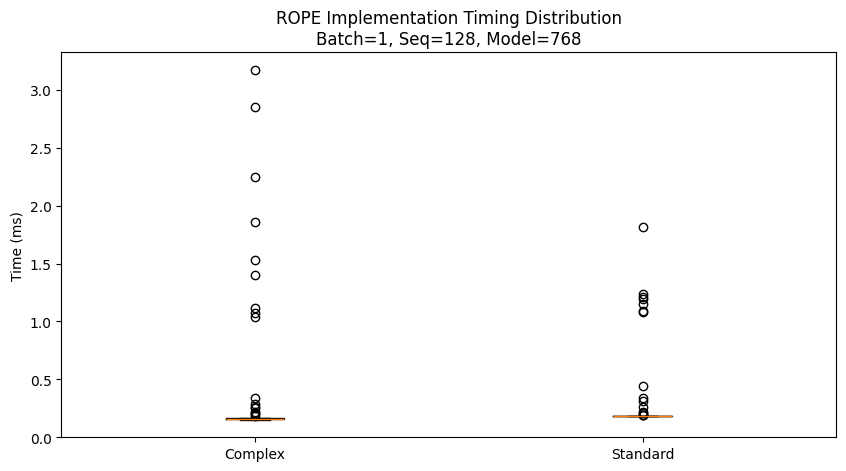


Benchmark Results (100 iterations):
Configuration: batch_size=32, seq_len=512, d_model=768, num_heads=12

Complex Implementation:
Mean time: 1.88 ms
Std dev: 0.14 ms

Standard Implementation:
Mean time: 2.52 ms
Std dev: 0.46 ms

Speedup: 1.34x


/tmp/ipykernel_360771/1668716528.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])


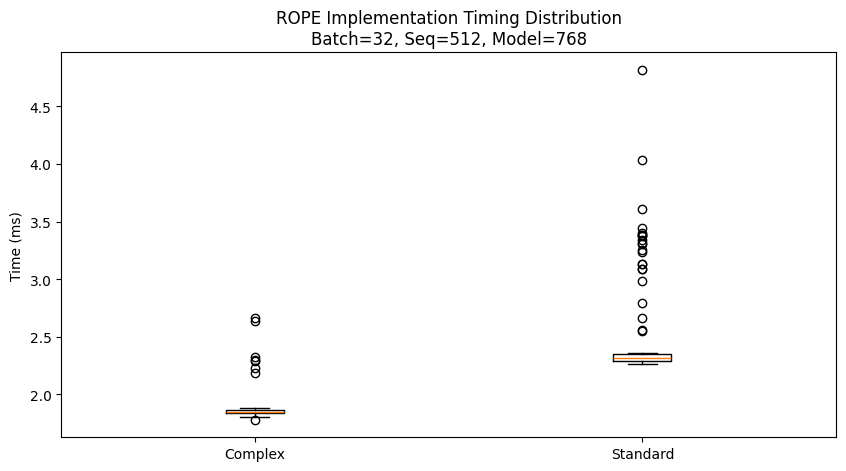


Benchmark Results (100 iterations):
Configuration: batch_size=8, seq_len=2048, d_model=768, num_heads=12

Complex Implementation:
Mean time: 1.96 ms
Std dev: 0.32 ms

Standard Implementation:
Mean time: 2.44 ms
Std dev: 0.30 ms

Speedup: 1.24x


/tmp/ipykernel_360771/1668716528.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])


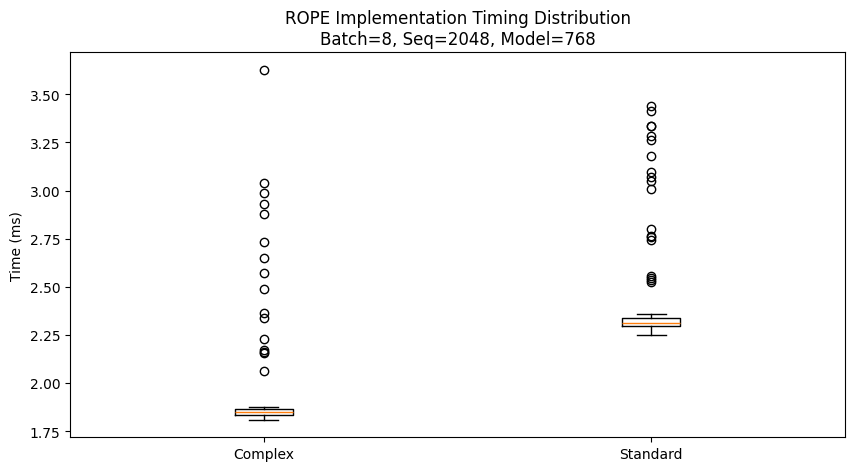

In [8]:
def benchmark_rope_implementations(batch_size=32, seq_len=512, d_model=768, num_heads=12, num_iterations=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create test inputs
    head_dim = d_model // num_heads
    q = torch.randn(batch_size, num_heads, seq_len, head_dim, device=device)
    k = torch.randn(batch_size, num_heads, seq_len, head_dim, device=device)

    # Precompute position embeddings for both implementations - explicitly set device
    freqs_cis_complex = complex_precompute_freqs_cis(head_dim, seq_len, device=device).to(device)
    cos, sin = precompute_freqs_cis(head_dim, seq_len, device=device)
    # Move cos/sin to device
    cos = cos.to(device)
    sin = sin.to(device)
    cos = torch.cat([cos, cos], dim=-1).unsqueeze(0).to(device)
    sin = torch.cat([sin, sin], dim=-1).unsqueeze(0).to(device)

    # Warmup
    for _ in range(10):
        complex_apply_rotary_position_embedding(q, k, freqs_cis_complex)
        apply_rotary_position_embedding(q, k, cos[:seq_len], sin[:seq_len])

    torch.cuda.synchronize()

    # Benchmark complex implementation
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)

    complex_times = []
    standard_times = []

    for _ in range(num_iterations):
        # Time complex implementation
        start_time.record()
        complex_apply_rotary_position_embedding(q, k, freqs_cis_complex)
        end_time.record()
        torch.cuda.synchronize()
        complex_times.append(start_time.elapsed_time(end_time))

        # Time standard implementation
        start_time.record()
        apply_rotary_position_embedding(q, k, cos[:seq_len], sin[:seq_len])
        end_time.record()
        torch.cuda.synchronize()
        standard_times.append(start_time.elapsed_time(end_time))

    # Calculate statistics
    complex_mean = sum(complex_times) / len(complex_times)
    complex_std = torch.tensor(complex_times).std().item()
    standard_mean = sum(standard_times) / len(standard_times)
    standard_std = torch.tensor(standard_times).std().item()

    print(f"\nBenchmark Results ({num_iterations} iterations):")
    print(f"Configuration: batch_size={batch_size}, seq_len={seq_len}, d_model={d_model}, num_heads={num_heads}")
    print(f"\nComplex Implementation:")
    print(f"Mean time: {complex_mean:.2f} ms")
    print(f"Std dev: {complex_std:.2f} ms")
    print(f"\nStandard Implementation:")
    print(f"Mean time: {standard_mean:.2f} ms")
    print(f"Std dev: {standard_std:.2f} ms")
    print(f"\nSpeedup: {standard_mean/complex_mean:.2f}x")

    return complex_times, standard_times

# Run benchmark with different configurations
configs = [
    (1, 128, 768, 12),    # Small batch, short sequence
    (32, 512, 768, 12),   # Medium batch, medium sequence
    (8, 2048, 768, 12),   # Small batch, long sequence
]

for batch_size, seq_len, d_model, num_heads in configs:
    complex_times, standard_times = benchmark_rope_implementations(
        batch_size=batch_size,
        seq_len=seq_len,
        d_model=d_model,
        num_heads=num_heads
    )

    # Plot timing distributions
    plt.figure(figsize=(10, 5))
    plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])
    plt.title(f'ROPE Implementation Timing Distribution\nBatch={batch_size}, Seq={seq_len}, Model={d_model}')
    plt.ylabel('Time (ms)')
    plt.show()

## Torch-compiled benchmark


Running benchmarks without torch.compile

Benchmark Results (100 iterations) without torch.compile:
Configuration: batch_size=1, seq_len=128, d_model=768, num_heads=12

Complex Implementation:
Mean time: 0.24 ms
Std dev: 0.28 ms

Standard Implementation:
Mean time: 0.22 ms
Std dev: 0.14 ms

Speedup: 0.92x


/tmp/ipykernel_360771/4175369209.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])


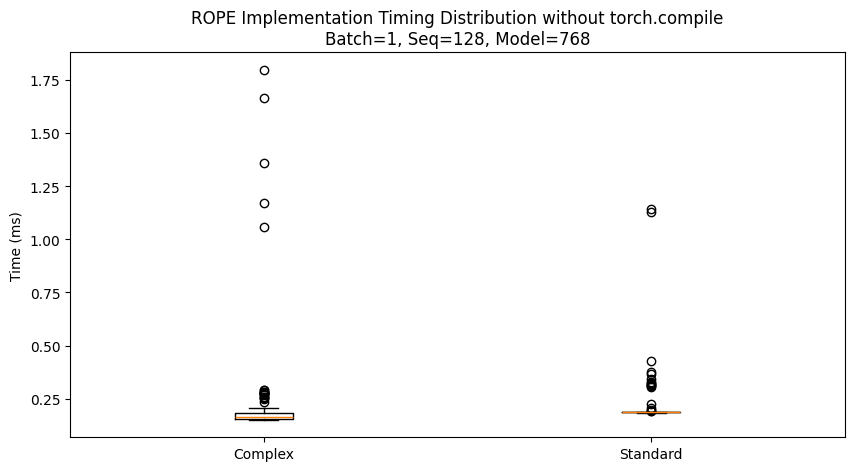


Benchmark Results (100 iterations) without torch.compile:
Configuration: batch_size=32, seq_len=512, d_model=768, num_heads=12

Complex Implementation:
Mean time: 1.99 ms
Std dev: 0.32 ms

Standard Implementation:
Mean time: 2.41 ms
Std dev: 0.28 ms

Speedup: 1.22x


/tmp/ipykernel_360771/4175369209.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])


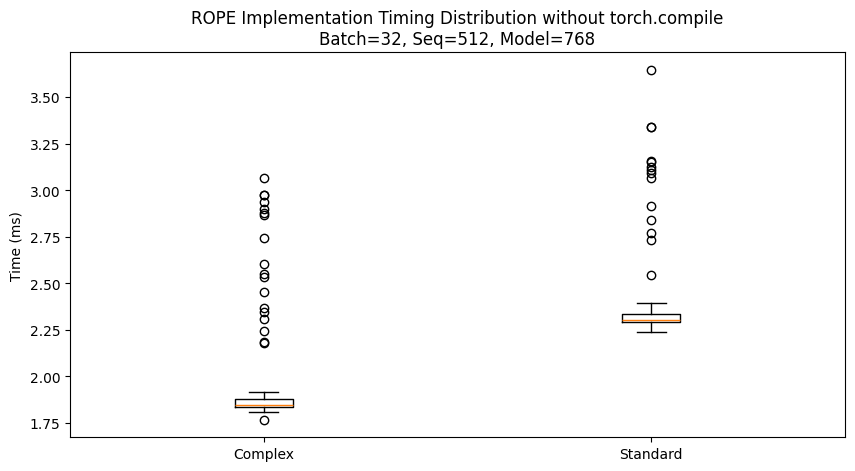


Benchmark Results (100 iterations) without torch.compile:
Configuration: batch_size=8, seq_len=2048, d_model=768, num_heads=12

Complex Implementation:
Mean time: 1.94 ms
Std dev: 0.27 ms

Standard Implementation:
Mean time: 2.40 ms
Std dev: 0.25 ms

Speedup: 1.24x


/tmp/ipykernel_360771/4175369209.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])


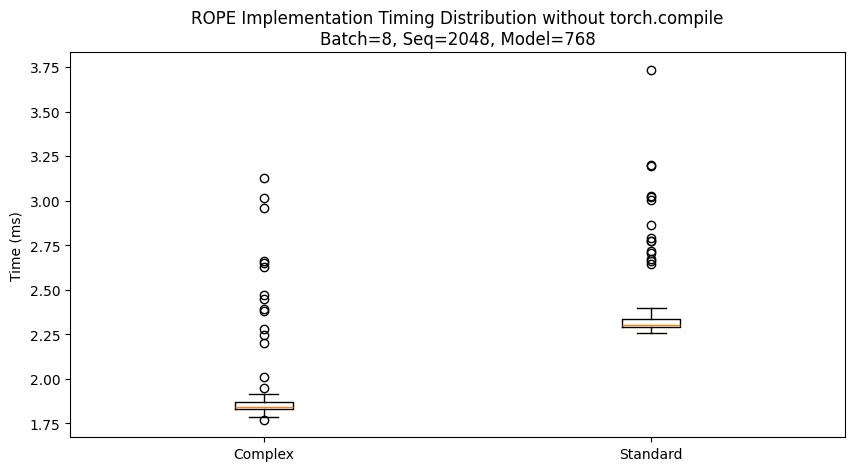


Running benchmarks with torch.compile


/home/tsikora/venv/lib/python3.12/site-packages/torch/_inductor/lowering.py:1881: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(



Benchmark Results (100 iterations) with torch.compile:
Configuration: batch_size=1, seq_len=128, d_model=768, num_heads=12

Complex Implementation:
Mean time: 0.03 ms
Std dev: 0.00 ms

Standard Implementation:
Mean time: 0.01 ms
Std dev: 0.00 ms

Speedup: 0.29x


/tmp/ipykernel_360771/4175369209.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])


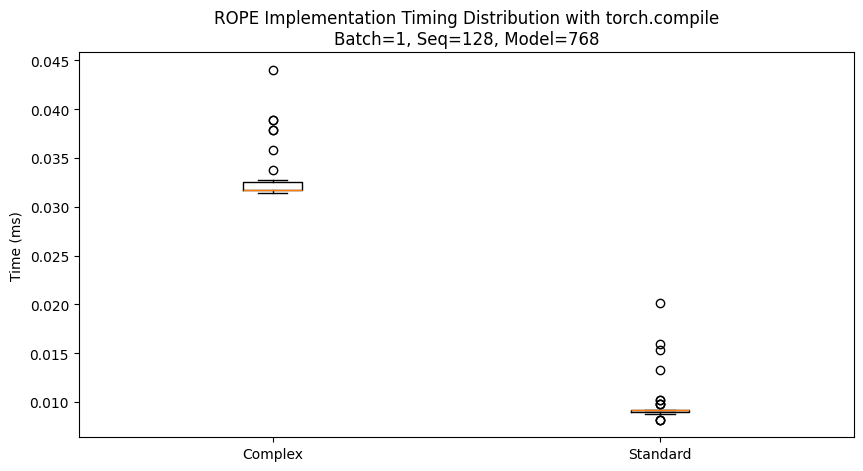


Benchmark Results (100 iterations) with torch.compile:
Configuration: batch_size=32, seq_len=512, d_model=768, num_heads=12

Complex Implementation:
Mean time: 1.43 ms
Std dev: 0.11 ms

Standard Implementation:
Mean time: 0.47 ms
Std dev: 0.03 ms

Speedup: 0.33x


/tmp/ipykernel_360771/4175369209.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])


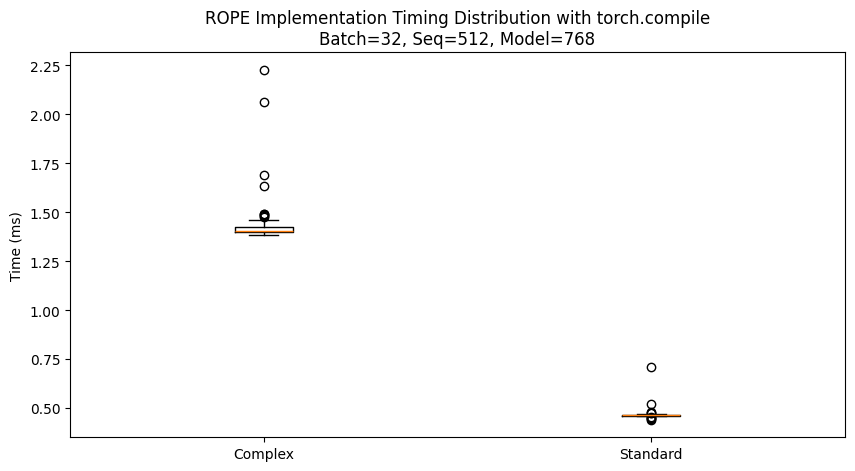


Benchmark Results (100 iterations) with torch.compile:
Configuration: batch_size=8, seq_len=2048, d_model=768, num_heads=12

Complex Implementation:
Mean time: 1.45 ms
Std dev: 0.18 ms

Standard Implementation:
Mean time: 0.47 ms
Std dev: 0.02 ms

Speedup: 0.32x


/tmp/ipykernel_360771/4175369209.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])


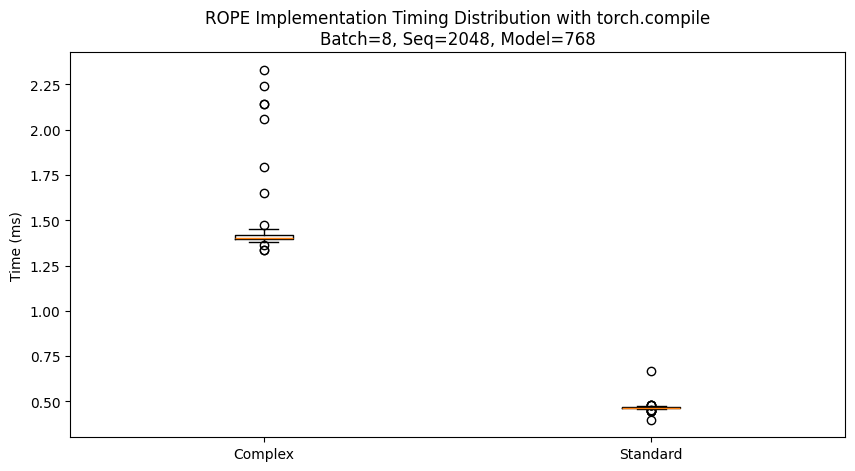


Benchmark Results (100 iterations) without torch.compile:
Configuration: batch_size=32, seq_len=512, d_model=768, num_heads=12

Complex Implementation:
Mean time: 1.93 ms
Std dev: 0.23 ms

Standard Implementation:
Mean time: 2.42 ms
Std dev: 0.30 ms

Speedup: 1.26x

Benchmark Results (100 iterations) with torch.compile:
Configuration: batch_size=32, seq_len=512, d_model=768, num_heads=12

Complex Implementation:
Mean time: 1.46 ms
Std dev: 0.19 ms

Standard Implementation:
Mean time: 0.47 ms
Std dev: 0.05 ms

Speedup: 0.32x


/tmp/ipykernel_360771/4175369209.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(config_results, labels=labels)


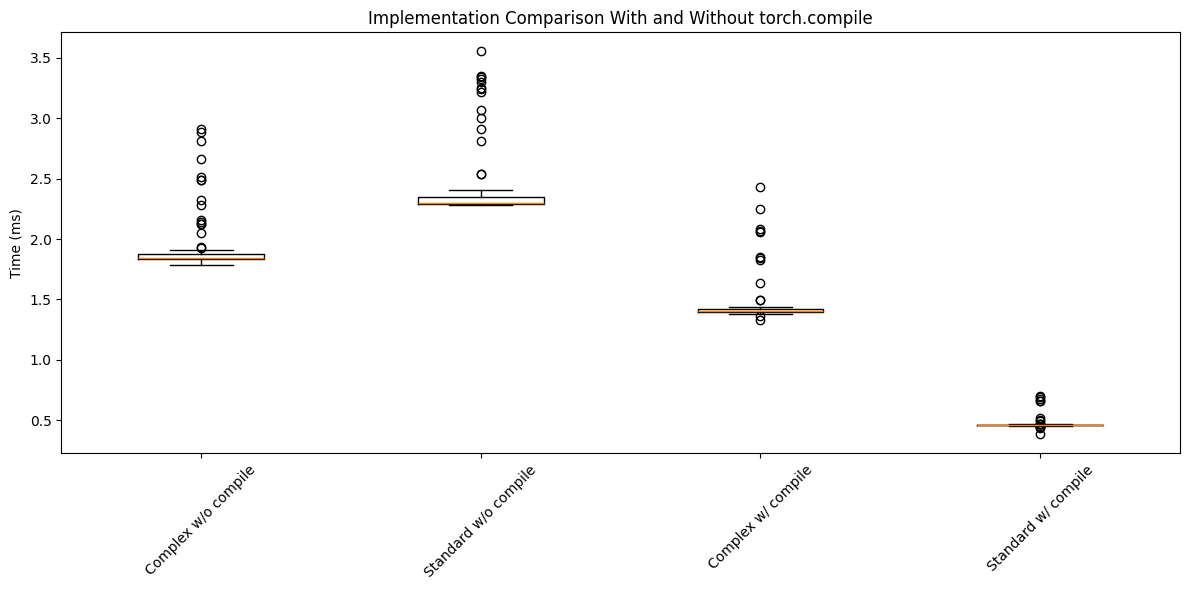

In [9]:
def benchmark_rope_implementations(batch_size=32, seq_len=512, d_model=768, num_heads=12, num_iterations=100, use_compile=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create test inputs
    head_dim = d_model // num_heads
    q = torch.randn(batch_size, num_heads, seq_len, head_dim, device=device)
    k = torch.randn(batch_size, num_heads, seq_len, head_dim, device=device)

    # Precompute position embeddings for both implementations
    freqs_cis_complex = complex_precompute_freqs_cis(head_dim, seq_len, device=device).to(device)
    cos, sin = precompute_freqs_cis(head_dim, seq_len, device=device)
    cos = cos.to(device)
    sin = sin.to(device)
    cos = torch.cat([cos, cos], dim=-1).unsqueeze(0).to(device)
    sin = torch.cat([sin, sin], dim=-1).unsqueeze(0).to(device)

    # Compile functions if requested
    if use_compile:
        complex_rope = torch.compile(complex_apply_rotary_position_embedding)
        standard_rope = torch.compile(apply_rotary_position_embedding)
    else:
        complex_rope = complex_apply_rotary_position_embedding
        standard_rope = apply_rotary_position_embedding

    # Warmup
    for _ in range(10):
        complex_rope(q, k, freqs_cis_complex)
        standard_rope(q, k, cos[:seq_len], sin[:seq_len])

    torch.cuda.synchronize()

    # Benchmark implementations
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)

    complex_times = []
    standard_times = []

    for _ in range(num_iterations):
        # Time complex implementation
        start_time.record()
        complex_rope(q, k, freqs_cis_complex)
        end_time.record()
        torch.cuda.synchronize()
        complex_times.append(start_time.elapsed_time(end_time))

        # Time standard implementation
        start_time.record()
        standard_rope(q, k, cos[:seq_len], sin[:seq_len])
        end_time.record()
        torch.cuda.synchronize()
        standard_times.append(start_time.elapsed_time(end_time))

    # Calculate statistics
    complex_mean = sum(complex_times) / len(complex_times)
    complex_std = torch.tensor(complex_times).std().item()
    standard_mean = sum(standard_times) / len(standard_times)
    standard_std = torch.tensor(standard_times).std().item()

    compile_status = "with torch.compile" if use_compile else "without torch.compile"
    print(f"\nBenchmark Results ({num_iterations} iterations) {compile_status}:")
    print(f"Configuration: batch_size={batch_size}, seq_len={seq_len}, d_model={d_model}, num_heads={num_heads}")
    print(f"\nComplex Implementation:")
    print(f"Mean time: {complex_mean:.2f} ms")
    print(f"Std dev: {complex_std:.2f} ms")
    print(f"\nStandard Implementation:")
    print(f"Mean time: {standard_mean:.2f} ms")
    print(f"Std dev: {standard_std:.2f} ms")
    print(f"\nSpeedup: {standard_mean/complex_mean:.2f}x")

    return complex_times, standard_times

# Configurations to test
configs = [
    (1, 128, 768, 12),    # Small batch, short sequence
    (32, 512, 768, 12),   # Medium batch, medium sequence
    (8, 2048, 768, 12),   # Small batch, long sequence
]

# Test both with and without torch.compile
for use_compile in [False, True]:
    print(f"\n{'='*80}")
    print(f"Running benchmarks {'with' if use_compile else 'without'} torch.compile")
    print(f"{'='*80}")

    for batch_size, seq_len, d_model, num_heads in configs:
        complex_times, standard_times = benchmark_rope_implementations(
            batch_size=batch_size,
            seq_len=seq_len,
            d_model=d_model,
            num_heads=num_heads,
            use_compile=use_compile
        )

        # Create plot
        plt.figure(figsize=(10, 5))
        plt.boxplot([complex_times, standard_times], labels=['Complex', 'Standard'])
        compile_status = "with torch.compile" if use_compile else "without torch.compile"
        plt.title(f'ROPE Implementation Timing Distribution {compile_status}\nBatch={batch_size}, Seq={seq_len}, Model={d_model}')
        plt.ylabel('Time (ms)')
        plt.show()

# Create comparison plots
def plot_comparison(config_results):
    labels = ['Complex w/o compile', 'Standard w/o compile', 'Complex w/ compile', 'Standard w/ compile']
    plt.figure(figsize=(12, 6))
    plt.boxplot(config_results, labels=labels)
    plt.title('Implementation Comparison With and Without torch.compile')
    plt.ylabel('Time (ms)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run detailed comparison for medium configuration
batch_size, seq_len, d_model, num_heads = 32, 512, 768, 12
results_no_compile = benchmark_rope_implementations(batch_size, seq_len, d_model, num_heads, use_compile=False)
results_compile = benchmark_rope_implementations(batch_size, seq_len, d_model, num_heads, use_compile=True)

plot_comparison([
    results_no_compile[0],  # Complex w/o compile
    results_no_compile[1],  # Standard w/o compile
    results_compile[0],     # Complex w/ compile
    results_compile[1]      # Standard w/ compile
])

## Liger and standard benchmark


Running benchmarks without torch.compile

Benchmark Results (100 iterations) without torch.compile:
Configuration: batch_size=1, seq_len=128, d_model=768, num_heads=12

Standard Implementation:
Mean time: 0.40 ms
Std dev: 0.57 ms

Liger Implementation:
Mean time: 0.05 ms
Std dev: 0.00 ms

Speedup (Liger vs Standard): 8.41x


/tmp/ipykernel_360771/1065800975.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([standard_times, liger_times], labels=['Standard', 'Liger'])


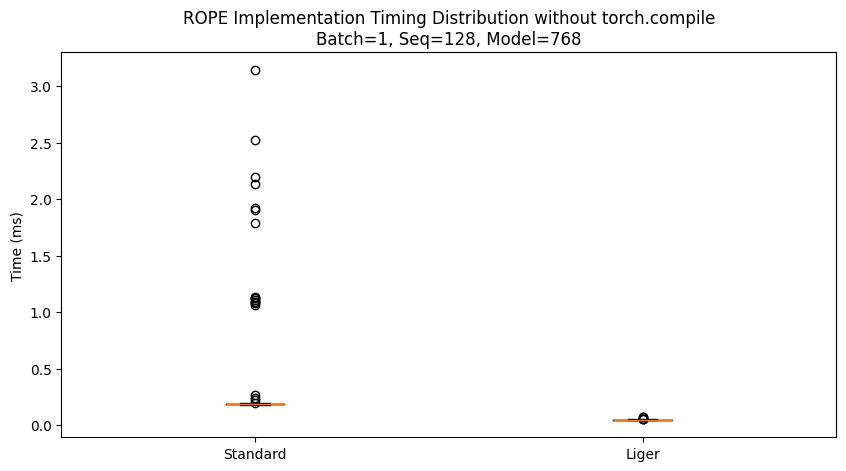


Benchmark Results (100 iterations) without torch.compile:
Configuration: batch_size=32, seq_len=512, d_model=768, num_heads=12

Standard Implementation:
Mean time: 2.53 ms
Std dev: 0.83 ms

Liger Implementation:
Mean time: 0.94 ms
Std dev: 0.08 ms

Speedup (Liger vs Standard): 2.68x


/tmp/ipykernel_360771/1065800975.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([standard_times, liger_times], labels=['Standard', 'Liger'])


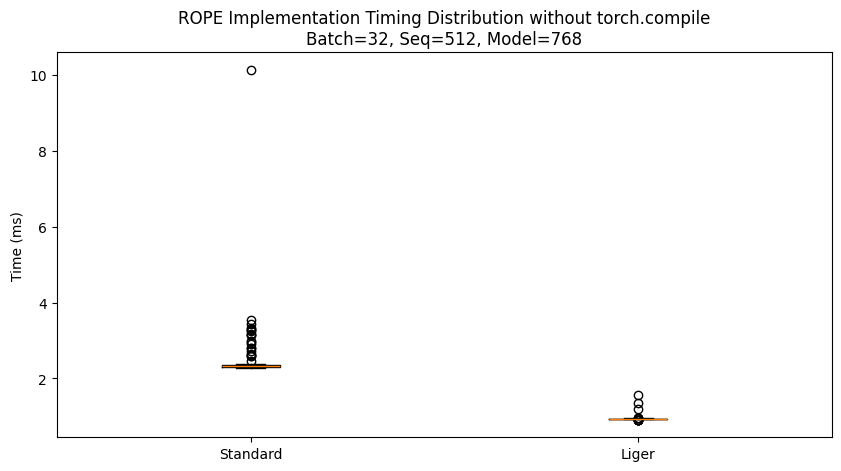


Benchmark Results (100 iterations) without torch.compile:
Configuration: batch_size=8, seq_len=2048, d_model=768, num_heads=12

Standard Implementation:
Mean time: 2.48 ms
Std dev: 0.37 ms

Liger Implementation:
Mean time: 0.95 ms
Std dev: 0.10 ms

Speedup (Liger vs Standard): 2.61x


/tmp/ipykernel_360771/1065800975.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([standard_times, liger_times], labels=['Standard', 'Liger'])


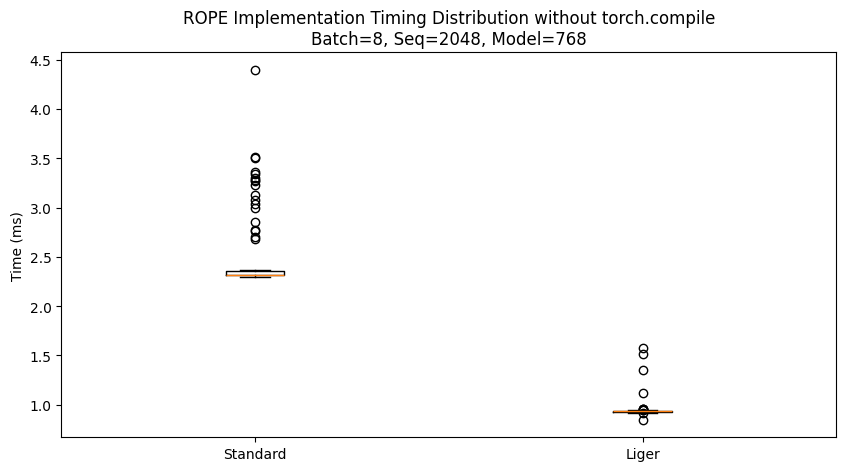


Running benchmarks with torch.compile

Benchmark Results (100 iterations) with torch.compile:
Configuration: batch_size=1, seq_len=128, d_model=768, num_heads=12

Standard Implementation:
Mean time: 0.00 ms
Std dev: 0.00 ms

Liger Implementation:
Mean time: 0.01 ms
Std dev: 0.00 ms

Speedup (Liger vs Standard): 0.52x


/tmp/ipykernel_360771/1065800975.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([standard_times, liger_times], labels=['Standard', 'Liger'])


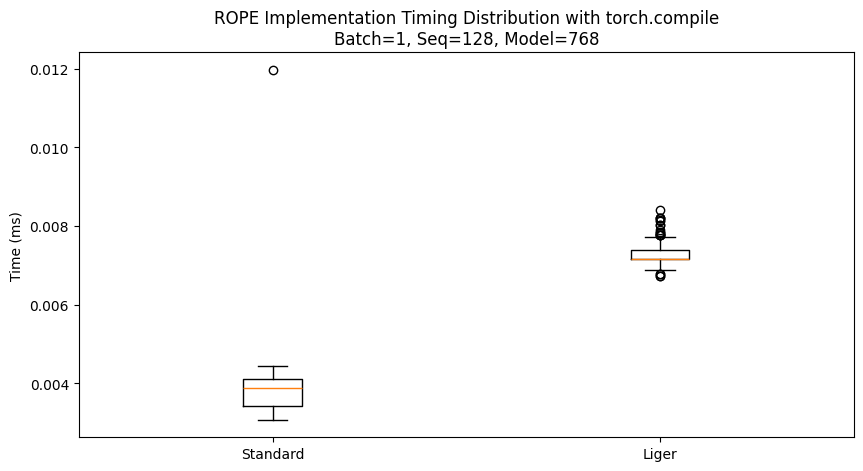


Benchmark Results (100 iterations) with torch.compile:
Configuration: batch_size=32, seq_len=512, d_model=768, num_heads=12

Standard Implementation:
Mean time: 0.47 ms
Std dev: 0.04 ms

Liger Implementation:
Mean time: 0.96 ms
Std dev: 0.10 ms

Speedup (Liger vs Standard): 0.49x


/tmp/ipykernel_360771/1065800975.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([standard_times, liger_times], labels=['Standard', 'Liger'])


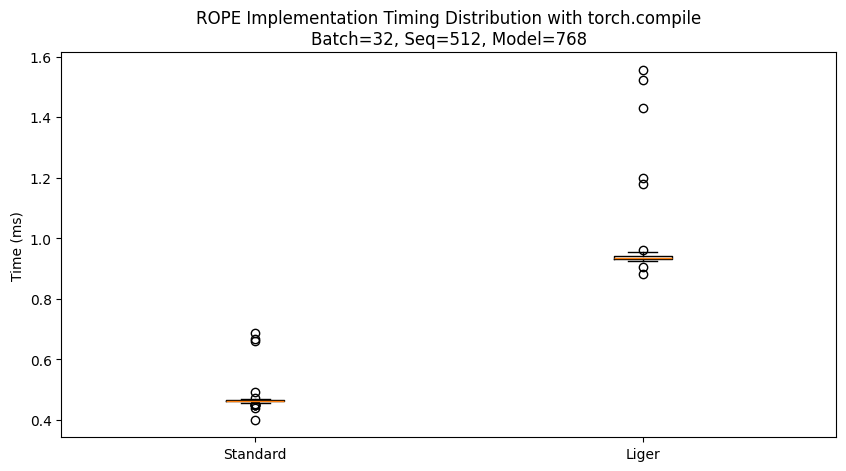


Benchmark Results (100 iterations) with torch.compile:
Configuration: batch_size=8, seq_len=2048, d_model=768, num_heads=12

Standard Implementation:
Mean time: 0.47 ms
Std dev: 0.05 ms

Liger Implementation:
Mean time: 0.97 ms
Std dev: 0.15 ms

Speedup (Liger vs Standard): 0.49x


/tmp/ipykernel_360771/1065800975.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([standard_times, liger_times], labels=['Standard', 'Liger'])


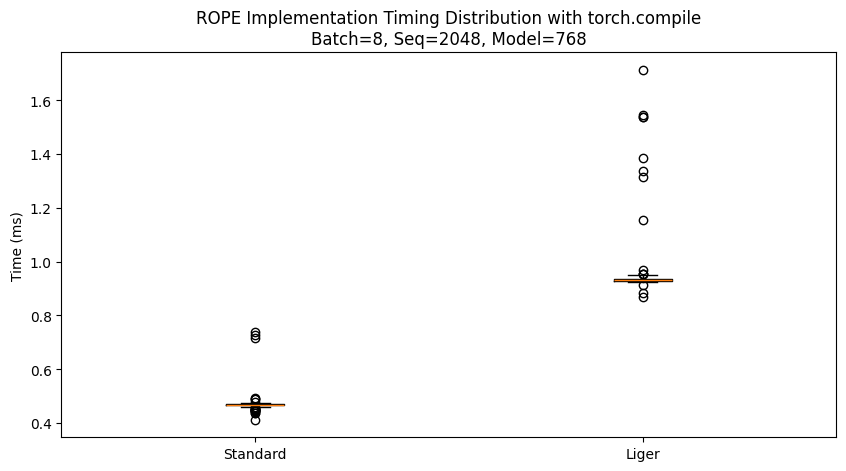


Benchmark Results (100 iterations) without torch.compile:
Configuration: batch_size=32, seq_len=512, d_model=768, num_heads=12

Standard Implementation:
Mean time: 2.47 ms
Std dev: 0.35 ms

Liger Implementation:
Mean time: 0.96 ms
Std dev: 0.12 ms

Speedup (Liger vs Standard): 2.58x

Benchmark Results (100 iterations) with torch.compile:
Configuration: batch_size=32, seq_len=512, d_model=768, num_heads=12

Standard Implementation:
Mean time: 0.47 ms
Std dev: 0.04 ms

Liger Implementation:
Mean time: 0.95 ms
Std dev: 0.06 ms

Speedup (Liger vs Standard): 0.49x


/tmp/ipykernel_360771/1065800975.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(config_results, labels=labels)


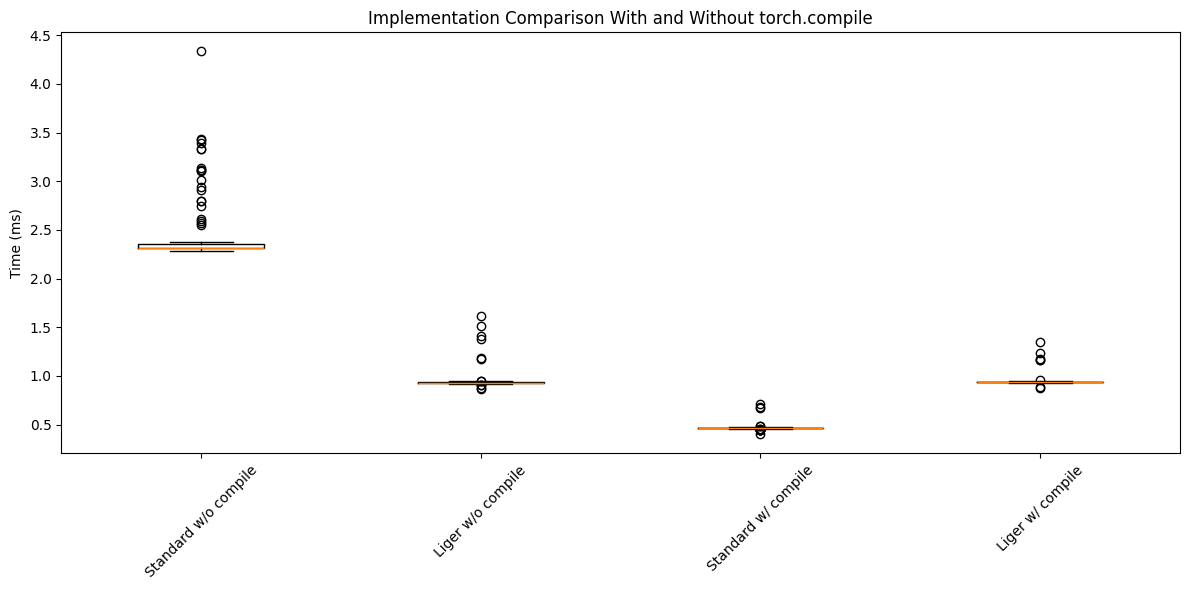

In [10]:
def benchmark_rope_implementations(batch_size=32, seq_len=512, d_model=768, num_heads=12, num_iterations=100, use_compile=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create test inputs
    head_dim = d_model // num_heads
    q = torch.randn(batch_size, num_heads, seq_len, head_dim, device=device)
    k = torch.randn(batch_size, num_heads, seq_len, head_dim, device=device)

    # Precompute position embeddings
    cos, sin = precompute_freqs_cis(head_dim, seq_len, device=device)
    cos = cos.to(device)
    sin = sin.to(device)

    # For standard implementation
    cos_standard = torch.cat([cos, cos], dim=-1).unsqueeze(0).to(device)
    sin_standard = torch.cat([sin, sin], dim=-1).unsqueeze(0).to(device)

    # Compile functions if requested
    if use_compile:
        standard_rope = torch.compile(apply_rotary_position_embedding)
    else:
        standard_rope = apply_rotary_position_embedding

    # Warmup
    for _ in range(10):
        standard_rope(q, k, cos_standard[:seq_len], sin_standard[:seq_len])
        LigerRopeFunction.apply(q, k, cos[:seq_len], sin[:seq_len], None, 1)

    torch.cuda.synchronize()

    # Benchmark implementations
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)

    standard_times = []
    liger_times = []

    for _ in range(num_iterations):
        # Time standard implementation
        start_time.record()
        standard_rope(q, k, cos_standard[:seq_len], sin_standard[:seq_len])
        end_time.record()
        torch.cuda.synchronize()
        standard_times.append(start_time.elapsed_time(end_time))

        # Time Liger implementation
        start_time.record()
        LigerRopeFunction.apply(q, k, cos[:seq_len], sin[:seq_len], None, 1)
        end_time.record()
        torch.cuda.synchronize()
        liger_times.append(start_time.elapsed_time(end_time))

    # Calculate statistics
    standard_mean = sum(standard_times) / len(standard_times)
    standard_std = torch.tensor(standard_times).std().item()
    liger_mean = sum(liger_times) / len(liger_times)
    liger_std = torch.tensor(liger_times).std().item()

    compile_status = "with torch.compile" if use_compile else "without torch.compile"
    print(f"\nBenchmark Results ({num_iterations} iterations) {compile_status}:")
    print(f"Configuration: batch_size={batch_size}, seq_len={seq_len}, d_model={d_model}, num_heads={num_heads}")
    print(f"\nStandard Implementation:")
    print(f"Mean time: {standard_mean:.2f} ms")
    print(f"Std dev: {standard_std:.2f} ms")
    print(f"\nLiger Implementation:")
    print(f"Mean time: {liger_mean:.2f} ms")
    print(f"Std dev: {liger_std:.2f} ms")
    print(f"\nSpeedup (Liger vs Standard): {standard_mean/liger_mean:.2f}x")

    return standard_times, liger_times

# Configurations to test
configs = [
    (1, 128, 768, 12),    # Small batch, short sequence
    (32, 512, 768, 12),   # Medium batch, medium sequence
    (8, 2048, 768, 12),   # Small batch, long sequence
]

# Test both with and without torch.compile
for use_compile in [False, True]:
    print(f"\n{'='*80}")
    print(f"Running benchmarks {'with' if use_compile else 'without'} torch.compile")
    print(f"{'='*80}")

    for batch_size, seq_len, d_model, num_heads in configs:
        standard_times, liger_times = benchmark_rope_implementations(
            batch_size=batch_size,
            seq_len=seq_len,
            d_model=d_model,
            num_heads=num_heads,
            use_compile=use_compile
        )

        # Create plot
        plt.figure(figsize=(10, 5))
        plt.boxplot([standard_times, liger_times], labels=['Standard', 'Liger'])
        compile_status = "with torch.compile" if use_compile else "without torch.compile"
        plt.title(f'ROPE Implementation Timing Distribution {compile_status}\nBatch={batch_size}, Seq={seq_len}, Model={d_model}')
        plt.ylabel('Time (ms)')
        plt.show()

# Create comparison plots
def plot_comparison(config_results):
    labels = ['Standard w/o compile', 'Liger w/o compile', 'Standard w/ compile', 'Liger w/ compile']
    plt.figure(figsize=(12, 6))
    plt.boxplot(config_results, labels=labels)
    plt.title('Implementation Comparison With and Without torch.compile')
    plt.ylabel('Time (ms)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run detailed comparison for medium configuration
batch_size, seq_len, d_model, num_heads = 32, 512, 768, 12
results_no_compile = benchmark_rope_implementations(batch_size, seq_len, d_model, num_heads, use_compile=False)
results_compile = benchmark_rope_implementations(batch_size, seq_len, d_model, num_heads, use_compile=True)

plot_comparison([
    results_no_compile[0],  # Standard w/o compile
    results_no_compile[1],  # Liger w/o compile
    results_compile[0],     # Standard w/ compile
    results_compile[1]      # Liger w/ compile
])